In [1]:
import re
import os
import numpy as np
import scipy as sp
import mne
import nilearn.plotting as nplt
import nilearn.image as image
import pickle
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from sklearn.metrics import roc_auc_score
from node_estimate import Node
from timewindow import TimeWindow, sliding_window
import nibabel as nib
from parcellation import freesurf_dict
import matplotlib.pyplot as plt

In [2]:
root= './'

tree = os.walk(os.path.join(root, 'Source'))

raw_files = []
src_files = []
inv_files = []
bem_files = []
fwd_files = []
trans_files = []
epochs_files = []
ave_files = []
stc_files = []

subjects_found = False

for walk in tree:
    for file in walk[2]:
        if re.search(r'.*raw\.fif', file):
            raw_files.append(os.path.join(walk[0], file))
        if re.search(r'.*src.*\.fif', file) or re.search(r'.*source.*space.*\.fif', file):
            src_files.append(os.path.join(walk[0], file))
        if re.search(r'.*inv.*\.fif', file) or re.search(r'.*inverse.*\.fif', file):
            inv_files.append(os.path.join(walk[0], file))
        if re.search(r'.*bem.*\.fif', file):
            bem_files.append(os.path.join(walk[0], file))
        if re.search(r'.*fwd.*\.fif', file) or re.search(r'.*forward.*\.fif', file):
            fwd_files.append(os.path.join(walk[0], file))
        if re.search(r'.*trans.*\.fif', file):
            trans_files.append(os.path.join(walk[0], file))
        if re.search(r'.*epo.*\.fif', file):
            epochs_files.append(os.path.join(walk[0], file))
        if re.search(r'.*ave.*\.fif', file):
            ave_files.append(os.path.join(walk[0], file))
        if re.search(r'.*stc.*\.fif.*', file):
            stc_files.append(os.path.join(walk[0], file))

    for subdir in walk[1]:
        if subdir == 'Subjects' or subdir == 'subjects' and not subjects_found:
            subjects_found = True
            subjects_dir = os.path.join(walk[0], subdir)
        elif subdir == 'Subjects' or subdir == 'subjects' and subjects_found:
            raise OSError("There are two subjects directories: {}, {}; Only one must be".format(
                subjects_dir, os.path.join(walk[0], subdir)
            ))

if not raw_files:
    raise OSError("No one of raw files are found. Raw file must have extension \'.fif\' and ends with \'raw\'")

if not subjects_found:
    raise OSError("Subjects directory not found!")
subjects = os.listdir(subjects_dir)

subject_dirs = []

for subject in subjects:
    subject_dirs.append(os.path.join(subjects_dir, subject))

raw_file = raw_files[0]
bem_file = bem_files[0]
src_file = src_files[0]
fwd_file = fwd_files[0]
trans_file = trans_files[0]

res_folder = os.path.join(root, 'Pipeline', subjects[0])

res_raw_folder = os.path.join(res_folder, 'Raw')
res_bem_folder = os.path.join(res_folder, 'Bem')
res_src_folder = os.path.join(res_folder, 'Src')
res_fwd_folder = os.path.join(res_folder, 'Fwd')
res_events_folder = os.path.join(res_folder, 'Events')
res_epochs_folder = os.path.join(res_folder, 'Epochs')
res_evoked_folder = os.path.join(res_folder, 'Evoked')
res_cov_folder = os.path.join(res_folder, 'Cov')
res_inv_folder = os.path.join(res_folder, 'Inv')
res_sLORETA_folder = os.path.join(res_folder, 'sLORETA')
res_nodes_folder = os.path.join(res_folder, 'NodesEstimate')
res_resec_folder = os.path.join(res_folder, 'Resection')

res_raw_file = os.path.join(res_raw_folder, 'raw.fif')
res_bem_file = os.path.join(res_bem_folder, 'raw_bem.fif')
res_src_file = os.path.join(res_src_folder, 'raw_src_ico5.fif')
res_fwd_file = os.path.join(res_fwd_folder, 'raw_fwd_ico5.fif')
res_events_file = os.path.join(res_events_folder, 'raw_eve.fif')
res_epochs_file = os.path.join(res_epochs_folder, 'raw_epo.fif')
res_evoked_file = os.path.join(res_evoked_folder, 'raw_ave.fif')
res_cov_file = os.path.join(res_cov_folder, 'noise_cov.fif')
res_inv_file = os.path.join(res_inv_folder, 'raw_inv.fif')
res_sLORETA_file = os.path.join(res_sLORETA_folder, 'sLORETA_raw_ave_inv.pkl')
res_nodes_strength_file = os.path.join(res_nodes_folder, 'nodes_strength_auc.dat')
res_pearson_nodes_file = os.path.join(res_nodes_folder, 'pearson_nodes.pkl')
res_plv_nodes_file = os.path.join(res_nodes_folder, 'plv_nodes.pkl')
res_resec_file = os.path.join(res_resec_folder, 'resection.pkl')

subject_dir = subject_dirs[0]
subject = subjects[0]

In [3]:
conductivity = (0.3,)  # for single layer
# conductivity = (0.3, 0.006, 0.3)  # for three layers
epochs_tmin, epochs_tmax = -15, 15
crop_time = 120
snr = 0.5  # use SNR smaller than 1 for raw data
lambda2 = 1.0 / snr ** 2
method = "sLORETA"
rfreq = 200
nfreq = 50
lfreq = 1
hfreq = 70

In [4]:
def mkdir(path):

    try:
        os.mkdir(path)

    except OSError:
        print("PIPELINE: creation of the directory %s failed" % path)

    else:
        print("PIPELINE: successfully created the directory %s " % path)


@sliding_window(size=400, overlap=0.5)
def do_nothing(sig):

    return sig


@sliding_window(400, 0.5)
def pearson(signals):

    nsigmals, lsignals = signals.shape
    out = np.zeros((nsigmals, nsigmals))

    for i in range(nsigmals):
        for j in range(nsigmals):

            if i == j:
                out[i, j] = 0
                continue

            out[i, j] = np.corrcoef(signals[i, :], signals[j, :])[0, 1]

    return out


@sliding_window(400, 0.5)
def phase_locking_value(signals):

    nsigmals, lsignals = signals.shape
    out = np.zeros((nsigmals, nsigmals, lsignals))

    for i in range(nsigmals):
        for j in range(nsigmals):

            sig1_fourier = np.fft.fft(signals[i])
            sig2_fourier = np.fft.fft(signals[j])
            plv_1_2 = []

            for k in range(lsignals):
                plv_1_2.append(sig1_fourier[k] * np.conj(sig2_fourier[k])/
                           (np.abs(sig1_fourier[k]) * np.abs(sig2_fourier[k])))

            out[i,j, :] = plv_1_2

    return np.array(out)


def mean_across_tw(twlist):

    if len(twlist[0].data.shape) == 2:
        l, w = twlist[0].data.shape
        voxel = voxel_from_tw(twlist)
        out = np.zeros((l, w))
        for i in range(l):
            for j in range(w):
                out[i, j] = np.mean(voxel[i, j, :])

        return out

    elif len(twlist[0].data.shape) == 3:
        l, w, h = twlist[0].data.shape
        voxel = voxel_from_tw(twlist)
        out = np.zeros((l, w, h))

        for i in range(l):
            for j in range(w):
                for k in range(h):
                    out[i, j, k] = np.mean(voxel[i, j, k, :])

        return out

    else:
        raise ValueError('Can not work with dimension less than two and higher than four')


def voxel_from_tw(twlist):

    if len(twlist[0].data.shape) == 2:
        l, w = twlist[0].data.shape
        h = len(twlist)
        voxel = np.zeros((l, w, h))

        for i in range(h):
            voxel[:, :, i] = twlist[i].data

        return voxel

    elif len(twlist[0].data.shape) == 3:
        l, w, h = twlist[0].data.shape
        d = len(twlist)
        voxel = np.zeros((l, w, h, d))

        for i in range(d):
            voxel[0:twlist[i].data.shape[0],
            0:twlist[i].data.shape[1],
            0:twlist[i].data.shape[2], i] = twlist[i].data

        return voxel

    else: raise ValueError('Can not work with dimension less than two and higher than four')


def eigencentrality(matrix):
    # only the greatest eigenvalue results in the desired centrality measure [Newman et al]
    if len(matrix.shape) == 2:
        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError('Can not compute centrality for non-square matrix')
        out = np.real(sp.linalg.eigvals(matrix))

        return out

    elif len(matrix.shape) == 3:

        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError('Matrix shape must be: [n x n x m]')

        c = [sp.linalg.eigvals(matrix[:, :, i]) for i in range(matrix.shape[-1])]
        out = [np.mean(np.real(np.array(c).T[i])) for i in range(matrix.shape[0])]

        return np.array(out)

    else: raise ValueError('Can not work with dimension less than two and higher than four')


def notchfir(raw, lfreq, nfreq, hfreq):

    meg_picks = mne.pick_types(raw.info, meg=True, eeg=False, eog=False)
    raw_filtered = raw \
        .load_data() \
        .notch_filter(nfreq, meg_picks) \
        .filter(l_freq=lfreq, h_freq=hfreq)

    return raw_filtered


def artifacts_clean(raw):

    ica = ICA(n_components=15, random_state=97)
    ica.fit(raw)
    ica.exclude = ica.find_bads_eog(raw)[0] + \
                  ica.find_bads_ecg(raw, method='correlation', threshold=3.0)[0]

    ica.apply(raw)

    return raw


def first_processing(raw):

    raw_cropped = raw.crop(tmax=crop_time)
    raw_filtered = notchfir(raw_cropped, lfreq, nfreq, hfreq)
    # raw_reconstructed = artifacts_clean(raw_filtered)
    raw_out = raw_filtered.pick_types(meg=True, eeg=False)

    del raw, raw_filtered

    return raw_out


def nodes_strength(label_tc, method):

    if method == 'pearson':
        pearson_matrices = pearson(label_tc)
        pears_mean = mean_across_tw(pearson_matrices)
        n_strength = np.array([])

        for i in range(pears_mean.shape[0]):
            n_strength = np.append(n_strength, np.sum(pears_mean[i, :]))

        return n_strength, pears_mean

    elif method == 'plv':
        plv_matrices = phase_locking_value(label_tc)
        plv_mean = mean_across_tw(plv_matrices)
        centrality = eigencentrality(plv_mean)

        return centrality, plv_mean


In [5]:
if not os.path.exists('./Pipeline'):
    mkdir('./Pipeline')

if not os.path.exists(res_folder):
    mkdir(res_folder)

In [6]:
if os.path.isfile(res_raw_file):
    raw = mne.io.read_raw_fif(res_raw_file)

elif os.path.isfile(raw_file):
    raw = mne.io.read_raw_fif(raw_file)
    raw.resample(rfreq, npad='auto')
    raw = first_processing(raw)
    path = res_raw_folder

    mkdir(path)

    raw.save(res_raw_file)

else:
    raise OSError('PIPELINE: Raw-file not found')


print(raw.info)

Opening raw data file ./Pipeline/B1C2/Raw/raw.fif...
    Range : 7800 ... 31800 =     39.000 ...   159.000 secs
Ready.
<Info | 24 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 acq_stim: 7 800.000000 2000.000000
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 GRAD, 102 MAG
 custom_ref_applied: False
 description: Vectorview system at moscow
 dev_head_t: MEG device -> head transform
 dig: 151 items (3 Cardinal, 4 HPI, 61 EEG, 83 Extra)
 events: 1 item (list)
 experimenter: meg
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 70.0 Hz
 meas_date: 2011-10-11 10:36:23 UTC
 meas_id: 4 items (dict)
 nchan: 306
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: epilepsy
 projs: []
 sfreq: 200.0 Hz
 subject_info: 3 items (dict)
>


In [7]:
if os.path.isfile(res_src_file):
    src = mne.read_source_spaces(res_src_file)

elif os.path.isfile(src_file):
    src = mne.read_source_spaces(src_file)
    path = res_src_folder

    mkdir(path)

    src.save(res_src_file)

else:
    print('PIPELINE: Source spaces not found, creating a new one...')
    src = mne.setup_source_space(subject, spacing='ico5', add_dist='patch', subjects_dir=subjects_dir)
    path = res_src_folder

    mkdir(path)

    src.save(res_src_file)

    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read


<ipython-input-7-a5d2cc32e07a>:2: RuntimeWarning: This filename (./Pipeline/B1C2/Src/raw_src_ico5.fif) does not conform to MNE naming conventions. All source space files should end with -src.fif, -src.fif.gz, _src.fif, _src.fif.gz, -fwd.fif, -fwd.fif.gz, _fwd.fif, _fwd.fif.gz, -inv.fif, -inv.fif.gz, _inv.fif or _inv.fif.gz
  src = mne.read_source_spaces(res_src_file)


In [8]:
if os.path.isfile(res_bem_file):
    bem = mne.read_bem_solution(res_bem_file)

elif os.path.isfile(bem_file):
    bem = mne.read_bem_solution(bem_file)
    path = res_bem_folder

    mkdir(path)

    mne.write_bem_solution(res_bem_file, bem)

else:
    print('PIPELINE: BEM-surface not found, creating a new one...')
    model = mne.make_bem_model(subject=subject, ico=4, conductivity=conductivity, subjects_dir=subject_dir)
    bem = mne.make_bem_solution(model)
    path = res_bem_folder

    mkdir(path)

    mne.write_bem_solution(res_bem_file, bem)

Loading surfaces...

Loading the solution matrix...

Homogeneous model surface loaded.
Loaded linear_collocation BEM solution from ./Pipeline/B1C2/Bem/raw_bem.fif


In [9]:
if os.path.isfile(res_fwd_file):
    fwd = mne.read_forward_solution(res_fwd_file)

elif os.path.isfile(fwd_file):
    fwd = mne.read_forward_solution(fwd_file)
    path = res_fwd_folder

    mkdir(path)

    mne.write_forward_solution(res_fwd_file, fwd)

else:
    print('PIPELINE: Forward solution not found, creating a new one...')
    fwd = mne.make_forward_solution(res_raw_file, trans=trans_file, src=src, bem=bem, meg=True, eeg=False,
                                    mindist=5.0, n_jobs=1, verbose=True)
    path = res_fwd_folder

    mkdir(path)

    mne.write_forward_solution(res_fwd_file, fwd)

Reading forward solution from ./Pipeline/B1C2/Fwd/raw_fwd_ico5.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (2047 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


<ipython-input-9-cbb4aca826bd>:2: RuntimeWarning: This filename (./Pipeline/B1C2/Fwd/raw_fwd_ico5.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution(res_fwd_file)


In [10]:
events = np.array([[
        raw.first_samp + raw.time_as_index(i)[0],
        0,
        1
    ] for i in range(1, 59)])

In [11]:
if os.path.isfile(res_epochs_file):
    epochs = mne.read_epochs(res_epochs_file)

else:
    print('PIPELINE: Epochs not found, creating a new one...')
    epochs = mne.Epochs(raw, events, tmin=-1, tmax=1,
                        preload=True)
    path = res_epochs_folder

    mkdir(path)

    epochs.save(res_epochs_file)

Reading ./Pipeline/B1C2/Epochs/raw_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated


In [12]:
if os.path.isfile(res_evoked_file):
    evoked = mne.read_evokeds(res_evoked_file)
else:
    print('PIPELINE: Evokeds not found, creating a new one...')
    evoked = epochs.average()
    path = res_evoked_folder

    mkdir(path)

    mne.write_evokeds(res_evoked_file, evoked)

    evoked = [evoked]

Reading ./Pipeline/B1C2/Evoked/raw_ave.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms (1)
        0 CTF compensation matrices available
        nave = 58 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
No baseline correction applied


In [13]:
# evoked[0].plot()

In [14]:
if os.path.isfile(res_cov_file):
    noise_cov = mne.read_cov(res_cov_file)

else:
    print('PIPELINE: Noise covariance not found, creating a new one...')
    noise_cov = mne.compute_covariance(epochs.copy().pick_types(meg=True, eeg=False, eog=False), tmin=-1, tmax=0,
                                       method='empirical')
    path = res_cov_folder

    mkdir(path)

    mne.write_cov(res_cov_file, noise_cov)

    306 x 306 full covariance (kind = 1) found.


In [15]:
if os.path.isfile(res_inv_file):
    inv = mne.minimum_norm.read_inverse_operator(res_inv_file)

else:
    print('PIPELINE: Inverse operator not found, creating a new one...')
    inv = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, noise_cov, depth=None, fixed=False)
    path = res_inv_folder

    mkdir(path)

    mne.minimum_norm.write_inverse_operator(res_inv_file, inv)

Reading inverse operator decomposition from ./Pipeline/B1C2/Inv/raw_inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    306 x 306 full covariance (kind = 1) found.
    Noise covariance matrix read.
    6141 x 6141 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    6141 x 6141 diagonal covariance (kind = 6) found.
    Orientation priors read.
    Did not find the desired covariance matrix (kind = 5)
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Source spaces transformed to the inverse solution coordinate frame


In [16]:


if os.path.isfile(res_sLORETA_file):
    print('Reading sLORETA solution...')
    stc = pickle.load(open(res_sLORETA_file, 'rb'))
    print('sLORETA has been read')

else:
    print('PIPELINE: sLORETA not found, creating a new one...')
    stc = mne.minimum_norm.apply_inverse_epochs(epochs,
                                         inv,
                                         lambda2,
                                         'sLORETA',
                                         pick_ori=None
                                         )
    path = res_sLORETA_folder

    mkdir(path)
    pickle.dump(stc, open(res_sLORETA_file, 'wb'))

Reading sLORETA solution...
sLORETA has been read


In [17]:
labels_parc = mne.read_labels_from_annot(subject, parc='aparc', subjects_dir=subjects_dir)

# label_tc = stc.extract_label_time_course(labels_parc, src, mode='mean_flip')

label_ts = mne.extract_label_time_course(stc, labels_parc, src, mode='mean_flip')

Reading labels from parcellation...
   read 34 labels from ./Source/Subjects/B1C2/label/lh.aparc.annot
   read 34 labels from ./Source/Subjects/B1C2/label/rh.aparc.annot
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: mean_flip)
Extracting time courses for 68 labels (mode: m

(68, 401)


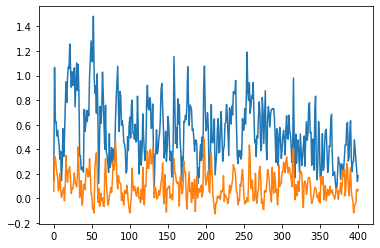

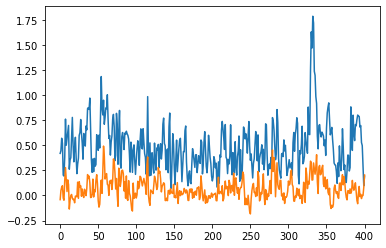

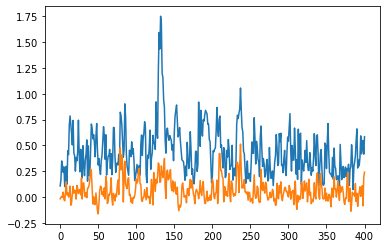

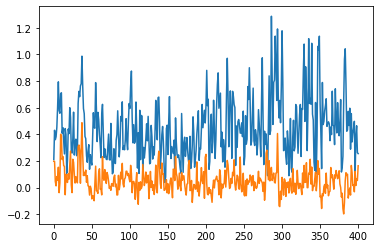

In [65]:
print(label_ts[0].shape)

plt.plot(np.arange(401), label_ts[0][10].T, np.arange(401), label_ts[0][36].T)
plt.show()
plt.plot(np.arange(401), label_ts[1][10].T, np.arange(401), label_ts[1][36].T)
plt.show()
plt.plot(np.arange(401), label_ts[2][10].T, np.arange(401), label_ts[2][36].T)
plt.show()
plt.plot(np.arange(401), label_ts[3][10].T, np.arange(401), label_ts[3][36].T)
plt.show()

In [ ]:
labels_aseg = mne.get_volume_labels_from_src(src, subject, subjects_dir)

labels = labels_parc + labels_aseg

label_names = [label.name for label in labels]

lh_labels = [name for name in label_names if name.endswith('lh')]

rh_labels = [name for name in label_names if name.endswith('rh')]

In [19]:
fmin = 30
fmax = 70
sfreq = 200

con, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(
    label_ts, method='plv', mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..2.000s for estimation (401 points)
    frequencies: 30.4Hz..69.8Hz (80 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLV
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectiv

In [55]:
label_ypos_lh = list()

for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos_lh.append(ypos)

try:
    idx = label_names.index('Brain-Stem')

except ValueError:
    pass

else:
    ypos = np.mean(labels[idx].pos[:, 1])
    lh_labels.append('Brain-Stem')
    label_ypos_lh.append(ypos)


lh_labels = [label for (yp, label) in sorted(zip(label_ypos_lh, lh_labels))]

rh_labels = [label[:-2] + 'rh' for label in lh_labels
             if label != 'Brain-Stem' and label[:-2] + 'rh' in rh_labels]


node_colors = [label.color for label in labels]

node_order = lh_labels[::-1] + rh_labels

node_angles = mne.viz.circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) // 2])
conmat = con[:, :, 0]

In [63]:
for i in range(67):
    print((conmat[:, i]))

[0.         0.26495155 0.37767609 0.15678561 0.46375177 0.3847681
 0.4718501  0.15397069 0.18091148 0.23462253 0.5079222  0.23758394
 0.29632021 0.37763329 0.18033191 0.4131761  0.3094003  0.51373687
 0.28274574 0.45946669 0.63545565 0.24675978 0.17653869 0.59755519
 0.37394311 0.45945997 0.65748385 0.48270733 0.12856408 0.17946894
 0.68615447 0.13812968 0.61058142 0.2269908  0.19199645 0.25362409
 0.21564701 0.14645128 0.38427451 0.12041241 0.13848554 0.18433948
 0.57240796 0.18697016 0.2671437  0.19758437 0.41607309 0.24800004
 0.38153695 0.27131706 0.36934474 0.19664385 0.35599592 0.20745293
 0.34781948 0.59369266 0.13854022 0.22160635 0.16081233 0.47697919
 0.83264115 0.15901551 0.14670394 0.18969153 0.38996856 0.36505468
 0.29548021 0.16350715]
[0.         0.         0.32410602 0.36340517 0.39890927 0.33794414
 0.3997292  0.34905763 0.1703043  0.30911333 0.1865722  0.48298338
 0.37497603 0.22788416 0.17423651 0.47395914 0.57901994 0.34100841
 0.64438368 0.28207083 0.70402258 0.507

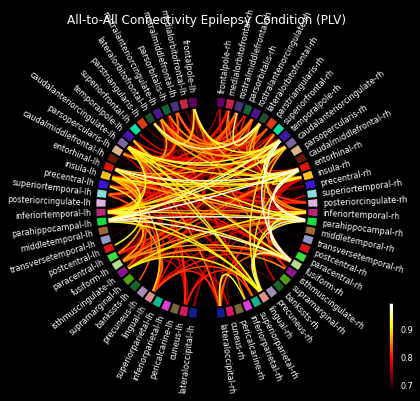

(<Figure size 576x576 with 2 Axes>,
 <PolarAxesSubplot:title={'center':'All-to-All Connectivity Epilepsy Condition (PLV)'}>)

In [21]:
fig = plt.figure(num=None, figsize=(8, 8), facecolor='black')
mne.viz.plot_connectivity_circle(conmat, label_names, n_lines=300,
                         node_angles=node_angles, node_colors=node_colors,
                         title='All-to-All Connectivity Epilepsy '
                         'Condition (PLV)', fig=fig)

In [22]:
# fmin = 30.
# fmax = 50.
# sfreq = 200
#
# con, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(
#     label_ts, method='plv', mode='multitaper', sfreq=sfreq, fmin=fmin,
#     fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
#

In [23]:
# fig = plt.figure(num=None, figsize=(8, 8), facecolor='black')
# mne.viz.plot_connectivity_circle(conmat, label_names, n_lines=300,
#                          node_angles=node_angles, node_colors=node_colors,
#                          title='All-to-All Connectivity Epilepsy '
#                          'Condition (PLV)', fig=fig)

In [24]:
# nodes strength

# plt.plot(n_strength, 'o')
# plt.title('Node Strength')
# plt.xlabel('node: number')
# plt.ylabel('node: strength')
# plt.show()

In [25]:
## compute roc curve
# resected_nodes = 15
#
# label_ind = np.zeros(len(n_strength))
# label_ind[0:resected_nodes] = True
# label_ind[resected_nodes+1:] = False
# Drs = roc_auc_score(label_ind, n_strength)

In [26]:
# if os.path.isfile(res_pearson_nodes_file):
#     print('Reading nodes...')
#     nodes = pickle.load(open(res_pearson_nodes_file, 'rb'))
#
# else:
#     print('PIPELINE: Pearson\'s Nodes file not found, create a new one')
#
#     if not os.path.exists(res_nodes_folder):
#         mkdir(res_nodes_folder)
#
#     nodes = []
#     n_strength, pearson_connectome = nodes_strength(label_ts, 'pearson')
#
#     for i in range(len(n_strength)):
#         nodes.append(Node(label_ts[i, :], n_strength[i], labels[i], 'Pearson', pearson_connectome[i, :]))
#
#     pickle.dump(nodes, open(res_pearson_nodes_file, 'wb'))
#
# coordinates = []
# n_strength = []
# for node in nodes:
#     coordinates.append(node.nilearn_coordinates)
#     n_strength.append(node.strength)
#
# nplt.plot_markers(n_strength, coordinates, node_cmap='black_red_r')
# nplt.show()
#

In [27]:
# if os.path.isfile(res_plv_nodes_file):
#     print('Reading nodes...')
#     nodes = pickle.load(open(res_plv_nodes_file, 'rb'))
#
# else:
#     print('PIPELINE: PLV Nodes file not found, create a new one')
#
#     if not os.path.exists(res_nodes_folder):
#         mkdir(res_nodes_folder)
#
#     nodes = []
#     n_strength, plv_connectome = nodes_strength(label_ts, 'plv')
#
#     for i in range(len(n_strength)):
#         nodes.append(Node(label_ts[i, :], n_strength[i], labels[i], 'PLV', plv_connectome[i, :, :]))
#
#     pickle.dump(nodes, open(res_plv_nodes_file, 'wb'))
#
# coordinates = []
# n_strength = []
# for node in nodes:
#     coordinates.append(node.nilearn_coordinates)
#     n_strength.append(node.strength)
#
# nplt.plot_markers(n_strength, coordinates, node_cmap='black_red_r')
# nplt.show()

In [28]:
## example how to get freesurf_dict

# vertexes = [mne.vertex_to_mni(
#     label.vertices,
#     hemis=0 if label.hemi == 'lh' else 1,
#     subject=subject, subjects_dir=subjects_dir
# )for label in labels]
# freesurf_dict_sample = {l[0].name: np.mean(l[1], axis=0) for l in zip(labels, vertexes)}

In [29]:
# # show one label
# nplt.plot_markers(np.zeros(vertexes[0].shape[0]), vertexes[0])
# nplt.show()

In [30]:
# # show one node
#
# nplt.plot_markers(np.array([0, 0]), np.array([
#     np.mean(vertexes[0], axis=0),
#     np.array([1000, 1000, 1000]) ## plot markers does not work with one node
# ]))
# nplt.show()

In [74]:
vertexes = [mne.vertex_to_mni(
    label.vertices,
    hemis=0 if label.hemi == 'lh' else 1,
    subject=subject, subjects_dir=subjects_dir
)for label in labels]

freesurf_dict_sample = {l[0].name: np.mean(l[1], axis=0) for l in zip(labels, vertexes)}
node_coordinates = np.array(list(freesurf_dict_sample.values()))

# print(node_coordinates)

In [37]:
if os.path.isfile(res_resec_file):
    print('Reading resection coordinates...')
    resec_coordinates = pickle.load(open(res_resec_file, 'rb'))
    print('Resection coordinates has been read')
else:
    print('PIPELINE: Resection file not found, create a new one')
    if not os.path.exists(res_resec_folder):
        mkdir(res_resec_folder)

    img = nib.load('Source/Subjects/B1C2/resection/resection.nii')
    res = np.array(img.get_data().tolist())
    img_coordinates = list()
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            for k in range(res.shape[2]):
                if res[i,j,k] != 0:
                    img_coordinates.append(np.array([i, j, k]))
    img_coordinates = np.array(img_coordinates)
    mni_coordinates = []
    for coordinate in img_coordinates:
        mni_coordinates.append(
            np.array(
                image.coord_transform(
                    coordinate[0],
                    coordinate[1],
                    coordinate[2],
                    img.affine
                    )
            )
        )
    
    resec_coordinates = np.array(mni_coordinates)
    pickle.dump(resec_coordinates, open(res_resec_file, 'wb'))

PIPELINE: Resection file not found, create a new one
PIPELINE: successfully created the directory ./Pipeline/B1C2/Resection 


<ipython-input-37-4781ccbd9e05>:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  res = np.array(img.get_data().tolist())


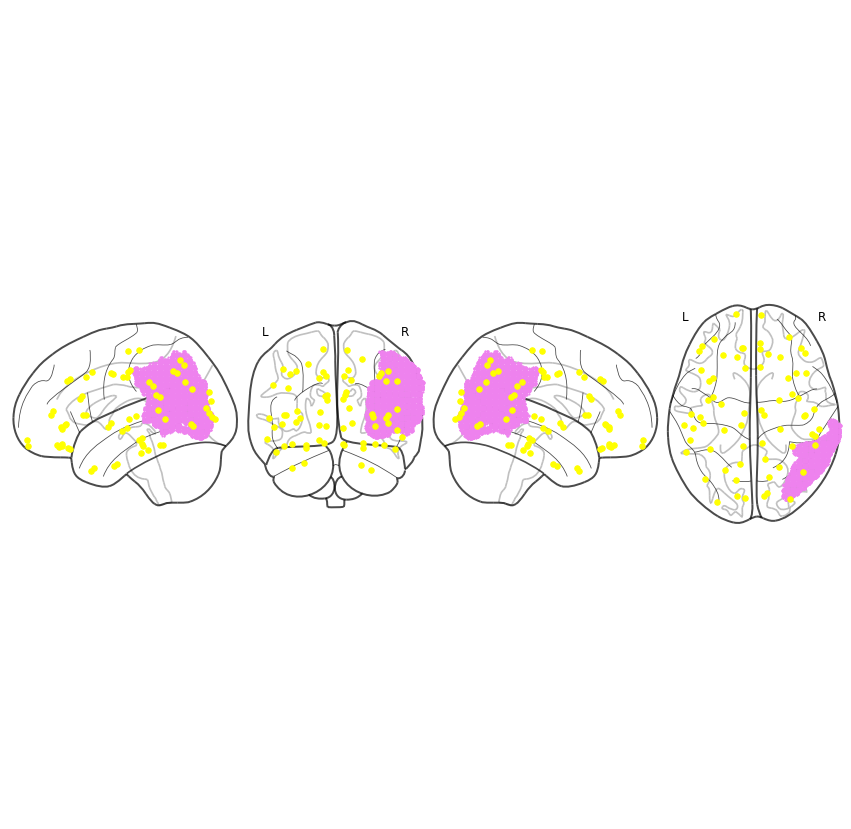

In [75]:
fig, ax = plt.subplots(figsize=(15,15))

display = nplt.plot_glass_brain(None, display_mode='lyrz', figure=fig, axes=ax)

display.add_markers(resec_coordinates, marker_color="violet", marker_size=1)

display.add_markers(node_coordinates, marker_color="yellow", marker_size=30)

<ipython-input-77-94c5681d79b2>:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if dist <= 1 and not node_coordinate in np.array(resected):


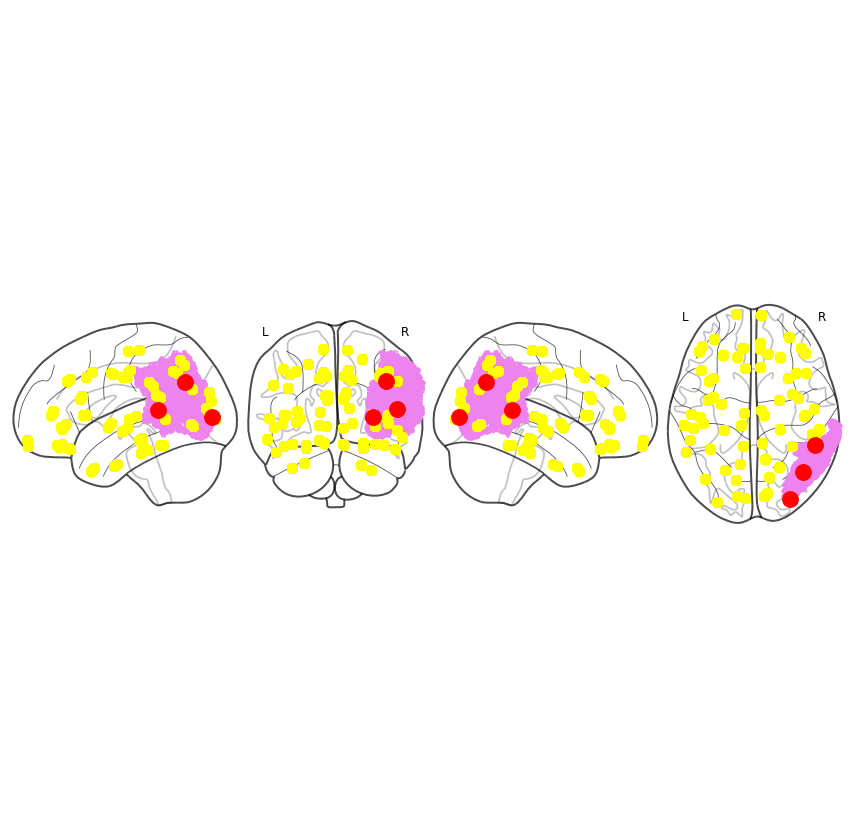

In [77]:
spared = list()
resected = list()

for node_coordinate in node_coordinates:
    for resec_coordinate in resec_coordinates:
        diff = node_coordinate - resec_coordinate
        dist = np.sqrt(diff[0]**2 + diff[1]**2 + diff[2]**2)
        if dist <= 1 and not node_coordinate in np.array(resected):
            resected.append(node_coordinate)
        else:
            spared.append(node_coordinate)

fig, ax = plt.subplots(figsize=(15,15))


display = nplt.plot_glass_brain(
    None, display_mode='lyrz', figure=fig, axes=ax)
display.add_markers(resec_coordinates, marker_color="violet", marker_size=1)
display.add_markers(np.array(spared), marker_color="yellow", marker_size=100)
display.add_markers(np.array(resected), marker_color="red", marker_size=250)

In [ ]:
del stc, src, raw, fwd,\
    bem, labels, label_ts, inv, noise_cov
